In [1]:
pip install tf2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 98.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [2]:
pip install mltu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: onnx
    Found existing installation: onnx 1.13.1
    Uninstalling onnx-1.13.1:
      Successfully uninstalled onnx-1.13.1
  Attempting uninstall: libros

In [3]:
import tensorflow as tf
from tqdm import tqdm
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices('GPU')]
except: pass

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen

from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

from mltu.dataProvider import DataProvider

In [4]:
from datetime import datetime
from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join('Models/04_sentence_recognition', datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ''
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 32
        self.learning_rate = 0.0005
        self.train_epochs = 100
        self.train_workers = 20

In [10]:
%cd /content/drive/MyDrive/English_IAM

/content/drive/MyDrive/English_IAM


In [11]:
pwd

'/content/drive/MyDrive/English_IAM'

In [5]:
from keras import layers
from keras.models import Model

from mltu.tensorflow.model_utils import residual_block

def train_model(input_dim, output_dim, activation='leaky_relu', dropout=0.2):
    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 32, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 128, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 128, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x9 = residual_block(x8, 128, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    blstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(blstm)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation='softmax', name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

In [19]:
sentences_txt_path = os.path.join('ascii', 'sentences.txt')
sentences_folder_path = os.path.join('sentences')

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = line_split[0][:8]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    # recplace '|' with ' ' in label
    label = label.replace('|', ' ')
    #print(label)
    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))

    max_len = max(max_len, len(label))
print(vocab)

100%|██████████| 16777/16777 [01:21<00:00, 204.90it/s]

{'D', 'L', 'p', '5', '#', 'b', 'l', '9', 'm', 'j', 'f', 'r', 's', 'g', '-', 'K', 'h', '"', '8', 'q', '0', 'P', 'n', 'F', 'J', '7', 'u', '1', 'C', 't', 'N', 'o', 'i', 'c', 'U', '(', '?', '3', 'Z', 'x', 'O', 'd', ':', 'A', 'a', 'w', '.', "'", ',', 'S', 'I', 'R', 'Y', 'z', 'y', 'e', 'W', '2', ')', '4', ';', 'V', '!', 'v', ' ', 'k', 'E', 'B', 'H', 'M', 'G', 'T', '6', '&', 'Q'}


In [ ]:
pwd

'/content/drive/MyDrive/English_IAM'

In [ ]:

import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices('GPU')]
except: pass

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric

#from model import train_model
#from configs import ModelConfigs

import os
from tqdm import tqdm

# Must download and extract datasets manually from https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database to Datasets\IAM_Sentences
sentences_txt_path = os.path.join( 'ascii', 'sentences.txt')
sentences_folder_path = os.path.join(  'sentences')

dataset, vocab, max_len = [], set(), 0
words = open(sentences_txt_path, "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[2] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    # replace '|' with ' ' in label
    label = label.replace('|', ' ')

    rel_path = os.path.join(sentences_folder_path, folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

# Create a ModelConfigs object to store model configurations
configs = ModelConfigs()

# Save vocab and maximum text length to configs
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()

# Create a data provider for the dataset
data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader()],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
        ],
)

# Split the dataset into training and validation sets
train_data_provider, val_data_provider = data_provider.split(split = 0.9)

# Augment training data with random brightness, rotation and erode/dilate
train_data_provider.augmentors = [
    RandomBrightness(), 
    RandomErodeDilate(),
    RandomSharpen(),
    ]

# Creating TensorFlow model architecture
model = train_model(
    input_dim = (configs.height, configs.width, 3),
    output_dim = len(configs.vocab),
)

# Compile the model and print summary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate), 
    loss=CTCloss(), 
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
        ],
    run_eagerly=False
)
model.summary(line_length=110)

# Define callbacks
earlystopper = EarlyStopping(monitor='val_CER', patience=20, verbose=1, mode='min')
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.h5", monitor='val_CER', verbose=1, save_best_only=True, mode='min')
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f'{configs.model_path}/logs', update_freq=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_CER', factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode='auto')
model2onnx = Model2onnx(f"{configs.model_path}/model.h5")

# Train the model
model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, reduceLROnPlat, tb_callback, model2onnx],
    workers=configs.train_workers
)

# Save training and validation datasets as csv files
train_data_provider.to_csv(os.path.join(configs.model_path, 'train.csv'))
val_data_provider.to_csv(os.path.join(configs.model_path, 'val.csv'))

100%|██████████| 16777/16777 [01:33<00:00, 178.76it/s] 
INFO:DataProvider:Skipping Dataset validation...


Model: "model_1"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input (InputLayer)                 [(None, 96, 1408, 3)]   0            []                                   
                                                                                                              
 lambda_1 (Lambda)                  (None, 96, 1408, 3)     0            ['input[0][0]']                      
                                                                                                              
 conv2d_24 (Conv2D)                 (None, 96, 1408, 32)    896          ['lambda_1[0][0]']                   
                                                                                                              
 batch_normalization_18 (BatchNorma  (None, 96, 1408, 32)   128          ['conv2d_24[0][0]']   

397/397 [==============================] - ETA: 0s - loss: 147.5368 - CER: 1.0616 - WER: 1.0000
Epoch 1: val_CER improved from inf to 1.00000, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 0; loss: 147.53680419921875; CER: 1.0616201162338257; WER: 1.0; val_loss: 138.5420684814453; val_CER: 1.0; val_WER: 1.0


397/397 [==============================] - 1011s 2s/step - loss: 147.5368 - CER: 1.0616 - WER: 1.0000 - val_loss: 138.5421 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 2/100
397/397 [==============================] - ETA: 0s - loss: 108.0243 - CER: 1.0000 - WER: 1.0000
Epoch 2: val_CER did not improve from 1.00000


INFO:root:Epoch 1; loss: 108.02432250976562; CER: 0.9999892711639404; WER: 0.9999552369117737; val_loss: 140.0182342529297; val_CER: 1.0; val_WER: 1.0


397/397 [==============================] - 110s 275ms/step - loss: 108.0243 - CER: 1.0000 - WER: 1.0000 - val_loss: 140.0182 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 3/100
397/397 [==============================] - ETA: 0s - loss: 107.1110 - CER: 0.9998 - WER: 0.9993
Epoch 3: val_CER did not improve from 1.00000


INFO:root:Epoch 2; loss: 107.1109619140625; CER: 0.9997618794441223; WER: 0.9993067383766174; val_loss: 116.6294174194336; val_CER: 1.0; val_WER: 1.0


397/397 [==============================] - 110s 275ms/step - loss: 107.1110 - CER: 0.9998 - WER: 0.9993 - val_loss: 116.6294 - val_CER: 1.0000 - val_WER: 1.0000 - lr: 5.0000e-04
Epoch 4/100
397/397 [==============================] - ETA: 0s - loss: 106.5571 - CER: 0.9936 - WER: 0.9955
Epoch 4: val_CER improved from 1.00000 to 0.99663, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 3; loss: 106.55713653564453; CER: 0.993593156337738; WER: 0.9954879879951477; val_loss: 118.30231475830078; val_CER: 0.9966340065002441; val_WER: 0.9992440938949585


397/397 [==============================] - 111s 278ms/step - loss: 106.5571 - CER: 0.9936 - WER: 0.9955 - val_loss: 118.3023 - val_CER: 0.9966 - val_WER: 0.9992 - lr: 5.0000e-04
Epoch 5/100
397/397 [==============================] - ETA: 0s - loss: 106.2183 - CER: 0.9824 - WER: 0.9929
Epoch 5: val_CER improved from 0.99663 to 0.98215, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 4; loss: 106.21829223632812; CER: 0.9824170470237732; WER: 0.9928844571113586; val_loss: 107.3767318725586; val_CER: 0.9821476936340332; val_WER: 0.9926567077636719


397/397 [==============================] - 111s 278ms/step - loss: 106.2183 - CER: 0.9824 - WER: 0.9929 - val_loss: 107.3767 - val_CER: 0.9821 - val_WER: 0.9927 - lr: 5.0000e-04
Epoch 6/100
397/397 [==============================] - ETA: 0s - loss: 105.6157 - CER: 0.9741 - WER: 0.9879
Epoch 6: val_CER improved from 0.98215 to 0.96072, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 5; loss: 105.61573028564453; CER: 0.9741495847702026; WER: 0.9879387617111206; val_loss: 111.06974792480469; val_CER: 0.9607247114181519; val_WER: 0.9826165437698364


397/397 [==============================] - 111s 278ms/step - loss: 105.6157 - CER: 0.9741 - WER: 0.9879 - val_loss: 111.0697 - val_CER: 0.9607 - val_WER: 0.9826 - lr: 5.0000e-04
Epoch 7/100
397/397 [==============================] - ETA: 0s - loss: 96.7374 - CER: 0.8545 - WER: 0.9836
Epoch 7: val_CER did not improve from 0.96072


INFO:root:Epoch 6; loss: 96.73743438720703; CER: 0.8545079231262207; WER: 0.9835813641548157; val_loss: 150.99642944335938; val_CER: 0.9616649150848389; val_WER: 0.9745737910270691


397/397 [==============================] - 110s 275ms/step - loss: 96.7374 - CER: 0.8545 - WER: 0.9836 - val_loss: 150.9964 - val_CER: 0.9617 - val_WER: 0.9746 - lr: 5.0000e-04
Epoch 8/100
397/397 [==============================] - ETA: 0s - loss: 64.7833 - CER: 0.5505 - WER: 0.8856
Epoch 8: val_CER improved from 0.96072 to 0.71888, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 7; loss: 64.78329467773438; CER: 0.5504893064498901; WER: 0.8856350183486938; val_loss: 85.4617691040039; val_CER: 0.7188846468925476; val_WER: 0.9239017367362976


397/397 [==============================] - 111s 279ms/step - loss: 64.7833 - CER: 0.5505 - WER: 0.8856 - val_loss: 85.4618 - val_CER: 0.7189 - val_WER: 0.9239 - lr: 5.0000e-04
Epoch 9/100
397/397 [==============================] - ETA: 0s - loss: 41.4307 - CER: 0.3370 - WER: 0.7255
Epoch 9: val_CER improved from 0.71888 to 0.26825, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 8; loss: 41.43071746826172; CER: 0.3369591236114502; WER: 0.7255149483680725; val_loss: 31.686769485473633; val_CER: 0.2682482600212097; val_WER: 0.6473832130432129


397/397 [==============================] - 111s 278ms/step - loss: 41.4307 - CER: 0.3370 - WER: 0.7255 - val_loss: 31.6868 - val_CER: 0.2682 - val_WER: 0.6474 - lr: 5.0000e-04
Epoch 10/100
397/397 [==============================] - ETA: 0s - loss: 30.6958 - CER: 0.2496 - WER: 0.6155
Epoch 10: val_CER did not improve from 0.26825


INFO:root:Epoch 9; loss: 30.695817947387695; CER: 0.24955686926841736; WER: 0.6154651641845703; val_loss: 32.32828903198242; val_CER: 0.2733413875102997; val_WER: 0.6340590119361877


397/397 [==============================] - 110s 275ms/step - loss: 30.6958 - CER: 0.2496 - WER: 0.6155 - val_loss: 32.3283 - val_CER: 0.2733 - val_WER: 0.6341 - lr: 5.0000e-04
Epoch 11/100
397/397 [==============================] - ETA: 0s - loss: 25.3527 - CER: 0.2100 - WER: 0.5513
Epoch 11: val_CER improved from 0.26825 to 0.16580, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 10; loss: 25.352678298950195; CER: 0.20995007455348969; WER: 0.551254391670227; val_loss: 19.820940017700195; val_CER: 0.1658003181219101; val_WER: 0.47346067428588867


397/397 [==============================] - 111s 278ms/step - loss: 25.3527 - CER: 0.2100 - WER: 0.5513 - val_loss: 19.8209 - val_CER: 0.1658 - val_WER: 0.4735 - lr: 5.0000e-04
Epoch 12/100
397/397 [==============================] - ETA: 0s - loss: 21.9163 - CER: 0.1831 - WER: 0.4989
Epoch 12: val_CER improved from 0.16580 to 0.15238, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 11; loss: 21.91633415222168; CER: 0.18313957750797272; WER: 0.4988690912723541; val_loss: 19.049434661865234; val_CER: 0.1523759514093399; val_WER: 0.4495995044708252


397/397 [==============================] - 111s 278ms/step - loss: 21.9163 - CER: 0.1831 - WER: 0.4989 - val_loss: 19.0494 - val_CER: 0.1524 - val_WER: 0.4496 - lr: 5.0000e-04
Epoch 13/100
397/397 [==============================] - ETA: 0s - loss: 19.7395 - CER: 0.1668 - WER: 0.4622
Epoch 13: val_CER improved from 0.15238 to 0.12731, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 12; loss: 19.739505767822266; CER: 0.1668320596218109; WER: 0.4622077941894531; val_loss: 15.699874877929688; val_CER: 0.1273145228624344; val_WER: 0.38749822974205017


397/397 [==============================] - 111s 278ms/step - loss: 19.7395 - CER: 0.1668 - WER: 0.4622 - val_loss: 15.6999 - val_CER: 0.1273 - val_WER: 0.3875 - lr: 5.0000e-04
Epoch 14/100
397/397 [==============================] - ETA: 0s - loss: 17.7412 - CER: 0.1509 - WER: 0.4292
Epoch 14: val_CER improved from 0.12731 to 0.12665, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 13; loss: 17.741186141967773; CER: 0.15094879269599915; WER: 0.4291679263114929; val_loss: 15.82507610321045; val_CER: 0.12665288150310516; val_WER: 0.3874085545539856


397/397 [==============================] - 111s 278ms/step - loss: 17.7412 - CER: 0.1509 - WER: 0.4292 - val_loss: 15.8251 - val_CER: 0.1267 - val_WER: 0.3874 - lr: 5.0000e-04
Epoch 15/100
397/397 [==============================] - ETA: 0s - loss: 16.2279 - CER: 0.1385 - WER: 0.4005
Epoch 15: val_CER improved from 0.12665 to 0.10422, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 14; loss: 16.227933883666992; CER: 0.13848218321800232; WER: 0.400488942861557; val_loss: 13.032715797424316; val_CER: 0.10421626269817352; val_WER: 0.3379695415496826


397/397 [==============================] - 111s 278ms/step - loss: 16.2279 - CER: 0.1385 - WER: 0.4005 - val_loss: 13.0327 - val_CER: 0.1042 - val_WER: 0.3380 - lr: 5.0000e-04
Epoch 16/100
397/397 [==============================] - ETA: 0s - loss: 15.1462 - CER: 0.1296 - WER: 0.3813
Epoch 16: val_CER improved from 0.10422 to 0.09907, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 15; loss: 15.146191596984863; CER: 0.12959305942058563; WER: 0.38132041692733765; val_loss: 12.28579330444336; val_CER: 0.09906748682260513; val_WER: 0.31864577531814575


397/397 [==============================] - 111s 278ms/step - loss: 15.1462 - CER: 0.1296 - WER: 0.3813 - val_loss: 12.2858 - val_CER: 0.0991 - val_WER: 0.3186 - lr: 5.0000e-04
Epoch 17/100
397/397 [==============================] - ETA: 0s - loss: 14.0972 - CER: 0.1214 - WER: 0.3628
Epoch 17: val_CER improved from 0.09907 to 0.08976, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 16; loss: 14.097237586975098; CER: 0.1214161217212677; WER: 0.3627556264400482; val_loss: 11.31039810180664; val_CER: 0.08976367861032486; val_WER: 0.292704313993454


397/397 [==============================] - 111s 277ms/step - loss: 14.0972 - CER: 0.1214 - WER: 0.3628 - val_loss: 11.3104 - val_CER: 0.0898 - val_WER: 0.2927 - lr: 5.0000e-04
Epoch 18/100
397/397 [==============================] - ETA: 0s - loss: 13.3223 - CER: 0.1153 - WER: 0.3486
Epoch 18: val_CER did not improve from 0.08976


INFO:root:Epoch 17; loss: 13.322331428527832; CER: 0.1152818575501442; WER: 0.34856003522872925; val_loss: 11.991374969482422; val_CER: 0.09523846209049225; val_WER: 0.30241549015045166


397/397 [==============================] - 109s 274ms/step - loss: 13.3223 - CER: 0.1153 - WER: 0.3486 - val_loss: 11.9914 - val_CER: 0.0952 - val_WER: 0.3024 - lr: 5.0000e-04
Epoch 19/100
397/397 [==============================] - ETA: 0s - loss: 12.4816 - CER: 0.1082 - WER: 0.3329
Epoch 19: val_CER improved from 0.08976 to 0.08081, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 18; loss: 12.481553077697754; CER: 0.1082383394241333; WER: 0.3329310417175293; val_loss: 10.136730194091797; val_CER: 0.08080729097127914; val_WER: 0.2727236747741699


397/397 [==============================] - 111s 277ms/step - loss: 12.4816 - CER: 0.1082 - WER: 0.3329 - val_loss: 10.1367 - val_CER: 0.0808 - val_WER: 0.2727 - lr: 5.0000e-04
Epoch 20/100
397/397 [==============================] - ETA: 0s - loss: 11.8888 - CER: 0.1048 - WER: 0.3202
Epoch 20: val_CER did not improve from 0.08081


INFO:root:Epoch 19; loss: 11.888766288757324; CER: 0.10482893884181976; WER: 0.32018864154815674; val_loss: 10.353596687316895; val_CER: 0.08143224567174911; val_WER: 0.2706926167011261


397/397 [==============================] - 109s 274ms/step - loss: 11.8888 - CER: 0.1048 - WER: 0.3202 - val_loss: 10.3536 - val_CER: 0.0814 - val_WER: 0.2707 - lr: 5.0000e-04
Epoch 21/100
397/397 [==============================] - ETA: 0s - loss: 11.2749 - CER: 0.0986 - WER: 0.3055
Epoch 21: val_CER improved from 0.08081 to 0.07690, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 20; loss: 11.274870872497559; CER: 0.09855446219444275; WER: 0.30553221702575684; val_loss: 9.822893142700195; val_CER: 0.07689856737852097; val_WER: 0.2667772173881531


397/397 [==============================] - 111s 277ms/step - loss: 11.2749 - CER: 0.0986 - WER: 0.3055 - val_loss: 9.8229 - val_CER: 0.0769 - val_WER: 0.2668 - lr: 5.0000e-04
Epoch 22/100
397/397 [==============================] - ETA: 0s - loss: 10.7415 - CER: 0.0943 - WER: 0.2982
Epoch 22: val_CER improved from 0.07690 to 0.07521, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 21; loss: 10.741491317749023; CER: 0.09433850646018982; WER: 0.2981582283973694; val_loss: 9.515942573547363; val_CER: 0.07520762830972672; val_WER: 0.25552603602409363


397/397 [==============================] - 111s 278ms/step - loss: 10.7415 - CER: 0.0943 - WER: 0.2982 - val_loss: 9.5159 - val_CER: 0.0752 - val_WER: 0.2555 - lr: 5.0000e-04
Epoch 23/100
397/397 [==============================] - ETA: 0s - loss: 10.2823 - CER: 0.0894 - WER: 0.2879
Epoch 23: val_CER improved from 0.07521 to 0.06872, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 22; loss: 10.282337188720703; CER: 0.08942048251628876; WER: 0.28790947794914246; val_loss: 8.770367622375488; val_CER: 0.06871756911277771; val_WER: 0.23583382368087769


397/397 [==============================] - 111s 277ms/step - loss: 10.2823 - CER: 0.0894 - WER: 0.2879 - val_loss: 8.7704 - val_CER: 0.0687 - val_WER: 0.2358 - lr: 5.0000e-04
Epoch 24/100
397/397 [==============================] - ETA: 0s - loss: 9.8456 - CER: 0.0850 - WER: 0.2769
Epoch 24: val_CER did not improve from 0.06872


INFO:root:Epoch 23; loss: 9.845575332641602; CER: 0.08504094928503036; WER: 0.2768916189670563; val_loss: 9.115335464477539; val_CER: 0.07066483050584793; val_WER: 0.2409977912902832


397/397 [==============================] - 109s 274ms/step - loss: 9.8456 - CER: 0.0850 - WER: 0.2769 - val_loss: 9.1153 - val_CER: 0.0707 - val_WER: 0.2410 - lr: 5.0000e-04
Epoch 25/100
397/397 [==============================] - ETA: 0s - loss: 9.2816 - CER: 0.0798 - WER: 0.2650
Epoch 25: val_CER improved from 0.06872 to 0.06800, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 24; loss: 9.281599998474121; CER: 0.07979714125394821; WER: 0.2650459408760071; val_loss: 8.923155784606934; val_CER: 0.06800325214862823; val_WER: 0.23543494939804077


397/397 [==============================] - 111s 277ms/step - loss: 9.2816 - CER: 0.0798 - WER: 0.2650 - val_loss: 8.9232 - val_CER: 0.0680 - val_WER: 0.2354 - lr: 5.0000e-04
Epoch 26/100
397/397 [==============================] - ETA: 0s - loss: 8.9566 - CER: 0.0751 - WER: 0.2550
Epoch 26: val_CER did not improve from 0.06800


INFO:root:Epoch 25; loss: 8.956574440002441; CER: 0.07508396357297897; WER: 0.25497058033943176; val_loss: 8.858698844909668; val_CER: 0.06948696076869965; val_WER: 0.236669659614563


397/397 [==============================] - 109s 274ms/step - loss: 8.9566 - CER: 0.0751 - WER: 0.2550 - val_loss: 8.8587 - val_CER: 0.0695 - val_WER: 0.2367 - lr: 5.0000e-04
Epoch 27/100
397/397 [==============================] - ETA: 0s - loss: 8.6296 - CER: 0.0725 - WER: 0.2518
Epoch 27: val_CER improved from 0.06800 to 0.06699, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 26; loss: 8.629593849182129; CER: 0.07254990190267563; WER: 0.2518453001976013; val_loss: 8.681743621826172; val_CER: 0.06698579341173172; val_WER: 0.2271047830581665


397/397 [==============================] - 111s 277ms/step - loss: 8.6296 - CER: 0.0725 - WER: 0.2518 - val_loss: 8.6817 - val_CER: 0.0670 - val_WER: 0.2271 - lr: 5.0000e-04
Epoch 28/100
397/397 [==============================] - ETA: 0s - loss: 8.2771 - CER: 0.0702 - WER: 0.2450
Epoch 28: val_CER improved from 0.06699 to 0.06613, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 27; loss: 8.277108192443848; CER: 0.07020244002342224; WER: 0.24495501816272736; val_loss: 8.848346710205078; val_CER: 0.06612860411405563; val_WER: 0.22833123803138733


397/397 [==============================] - 111s 277ms/step - loss: 8.2771 - CER: 0.0702 - WER: 0.2450 - val_loss: 8.8483 - val_CER: 0.0661 - val_WER: 0.2283 - lr: 5.0000e-04
Epoch 29/100
397/397 [==============================] - ETA: 0s - loss: 7.8698 - CER: 0.0655 - WER: 0.2338
Epoch 29: val_CER improved from 0.06613 to 0.06395, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 28; loss: 7.869755744934082; CER: 0.06549998372793198; WER: 0.23376676440238953; val_loss: 8.607595443725586; val_CER: 0.0639534592628479; val_WER: 0.22169220447540283


397/397 [==============================] - 111s 277ms/step - loss: 7.8698 - CER: 0.0655 - WER: 0.2338 - val_loss: 8.6076 - val_CER: 0.0640 - val_WER: 0.2217 - lr: 5.0000e-04
Epoch 30/100
397/397 [==============================] - ETA: 0s - loss: 7.6995 - CER: 0.0645 - WER: 0.2282
Epoch 30: val_CER did not improve from 0.06395


INFO:root:Epoch 29; loss: 7.699471950531006; CER: 0.06446003168821335; WER: 0.22824090719223022; val_loss: 8.959643363952637; val_CER: 0.06661688536405563; val_WER: 0.22768636047840118


397/397 [==============================] - 109s 274ms/step - loss: 7.6995 - CER: 0.0645 - WER: 0.2282 - val_loss: 8.9596 - val_CER: 0.0666 - val_WER: 0.2277 - lr: 5.0000e-04
Epoch 31/100
397/397 [==============================] - ETA: 0s - loss: 7.7807 - CER: 0.0661 - WER: 0.2300
Epoch 31: val_CER did not improve from 0.06395


INFO:root:Epoch 30; loss: 7.780663967132568; CER: 0.06614100188016891; WER: 0.22996395826339722; val_loss: 9.186948776245117; val_CER: 0.07157842814922333; val_WER: 0.2423522025346756


397/397 [==============================] - 109s 274ms/step - loss: 7.7807 - CER: 0.0661 - WER: 0.2300 - val_loss: 9.1869 - val_CER: 0.0716 - val_WER: 0.2424 - lr: 5.0000e-04
Epoch 32/100
397/397 [==============================] - ETA: 0s - loss: 7.1557 - CER: 0.0608 - WER: 0.2177
Epoch 32: val_CER did not improve from 0.06395


INFO:root:Epoch 31; loss: 7.155716419219971; CER: 0.060800448060035706; WER: 0.21767807006835938; val_loss: 8.464073181152344; val_CER: 0.06421483308076859; val_WER: 0.2202770859003067


397/397 [==============================] - 109s 274ms/step - loss: 7.1557 - CER: 0.0608 - WER: 0.2177 - val_loss: 8.4641 - val_CER: 0.0642 - val_WER: 0.2203 - lr: 5.0000e-04
Epoch 33/100
397/397 [==============================] - ETA: 0s - loss: 6.8925 - CER: 0.0578 - WER: 0.2100
Epoch 33: val_CER did not improve from 0.06395


INFO:root:Epoch 32; loss: 6.892493724822998; CER: 0.057825151830911636; WER: 0.21001632511615753; val_loss: 122.9090805053711; val_CER: 0.7743031978607178; val_WER: 0.9394000768661499


397/397 [==============================] - 109s 274ms/step - loss: 6.8925 - CER: 0.0578 - WER: 0.2100 - val_loss: 122.9091 - val_CER: 0.7743 - val_WER: 0.9394 - lr: 5.0000e-04
Epoch 34/100
397/397 [==============================] - ETA: 0s - loss: 6.6258 - CER: 0.0562 - WER: 0.2059
Epoch 34: val_CER improved from 0.06395 to 0.06262, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 33; loss: 6.625772953033447; CER: 0.056197091937065125; WER: 0.2058824598789215; val_loss: 8.186141014099121; val_CER: 0.06261954456567764; val_WER: 0.2157413810491562


397/397 [==============================] - 115s 288ms/step - loss: 6.6258 - CER: 0.0562 - WER: 0.2059 - val_loss: 8.1861 - val_CER: 0.0626 - val_WER: 0.2157 - lr: 5.0000e-04
Epoch 35/100
397/397 [==============================] - ETA: 0s - loss: 7.0299 - CER: 0.0634 - WER: 0.2161
Epoch 35: val_CER improved from 0.06262 to 0.06079, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 34; loss: 7.029924392700195; CER: 0.06336427479982376; WER: 0.21606451272964478; val_loss: 8.16928482055664; val_CER: 0.060792259871959686; val_WER: 0.20813557505607605


397/397 [==============================] - 110s 277ms/step - loss: 7.0299 - CER: 0.0634 - WER: 0.2161 - val_loss: 8.1693 - val_CER: 0.0608 - val_WER: 0.2081 - lr: 5.0000e-04
Epoch 36/100
397/397 [==============================] - ETA: 0s - loss: 6.3532 - CER: 0.0545 - WER: 0.1987
Epoch 36: val_CER improved from 0.06079 to 0.05902, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 35; loss: 6.353229999542236; CER: 0.0545220822095871; WER: 0.1986822932958603; val_loss: 8.0425386428833; val_CER: 0.059015918523073196; val_WER: 0.2034369558095932


397/397 [==============================] - 111s 277ms/step - loss: 6.3532 - CER: 0.0545 - WER: 0.1987 - val_loss: 8.0425 - val_CER: 0.0590 - val_WER: 0.2034 - lr: 5.0000e-04
Epoch 37/100
397/397 [==============================] - ETA: 0s - loss: 5.9845 - CER: 0.0508 - WER: 0.1902
Epoch 37: val_CER did not improve from 0.05902


INFO:root:Epoch 36; loss: 5.9844841957092285; CER: 0.0507919080555439; WER: 0.19015489518642426; val_loss: 8.499553680419922; val_CER: 0.06182194873690605; val_WER: 0.21077531576156616


397/397 [==============================] - 109s 274ms/step - loss: 5.9845 - CER: 0.0508 - WER: 0.1902 - val_loss: 8.4996 - val_CER: 0.0618 - val_WER: 0.2108 - lr: 5.0000e-04
Epoch 38/100
397/397 [==============================] - ETA: 0s - loss: 5.7660 - CER: 0.0489 - WER: 0.1838
Epoch 38: val_CER improved from 0.05902 to 0.05631, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 37; loss: 5.76597261428833; CER: 0.048896677792072296; WER: 0.18375034630298615; val_loss: 7.592344284057617; val_CER: 0.056309908628463745; val_WER: 0.1962871104478836


397/397 [==============================] - 115s 288ms/step - loss: 5.7660 - CER: 0.0489 - WER: 0.1838 - val_loss: 7.5923 - val_CER: 0.0563 - val_WER: 0.1963 - lr: 5.0000e-04
Epoch 39/100
397/397 [==============================] - ETA: 0s - loss: 5.6303 - CER: 0.0479 - WER: 0.1817
Epoch 39: val_CER did not improve from 0.05631


INFO:root:Epoch 38; loss: 5.630276203155518; CER: 0.047853779047727585; WER: 0.18169541656970978; val_loss: 7.757727146148682; val_CER: 0.05750955268740654; val_WER: 0.19965243339538574


397/397 [==============================] - 109s 274ms/step - loss: 5.6303 - CER: 0.0479 - WER: 0.1817 - val_loss: 7.7577 - val_CER: 0.0575 - val_WER: 0.1997 - lr: 5.0000e-04
Epoch 40/100
397/397 [==============================] - ETA: 0s - loss: 5.4521 - CER: 0.0463 - WER: 0.1771
Epoch 40: val_CER improved from 0.05631 to 0.05628, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 39; loss: 5.452062129974365; CER: 0.046339355409145355; WER: 0.17705567181110382; val_loss: 7.9105119705200195; val_CER: 0.056282177567481995; val_WER: 0.1989535391330719


397/397 [==============================] - 110s 277ms/step - loss: 5.4521 - CER: 0.0463 - WER: 0.1771 - val_loss: 7.9105 - val_CER: 0.0563 - val_WER: 0.1990 - lr: 5.0000e-04
Epoch 41/100
397/397 [==============================] - ETA: 0s - loss: 5.8007 - CER: 0.0506 - WER: 0.1871
Epoch 41: val_CER did not improve from 0.05628


INFO:root:Epoch 40; loss: 5.800722122192383; CER: 0.05062162131071091; WER: 0.18712957203388214; val_loss: 7.785869121551514; val_CER: 0.061359867453575134; val_WER: 0.20891651511192322


397/397 [==============================] - 109s 274ms/step - loss: 5.8007 - CER: 0.0506 - WER: 0.1871 - val_loss: 7.7859 - val_CER: 0.0614 - val_WER: 0.2089 - lr: 5.0000e-04
Epoch 42/100
397/397 [==============================] - ETA: 0s - loss: 5.4478 - CER: 0.0508 - WER: 0.1793
Epoch 42: val_CER improved from 0.05628 to 0.05452, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 41; loss: 5.447819232940674; CER: 0.05078490078449249; WER: 0.17934907972812653; val_loss: 7.692060947418213; val_CER: 0.054524049162864685; val_WER: 0.18795762956142426


397/397 [==============================] - 115s 288ms/step - loss: 5.4478 - CER: 0.0508 - WER: 0.1793 - val_loss: 7.6921 - val_CER: 0.0545 - val_WER: 0.1880 - lr: 5.0000e-04
Epoch 43/100
397/397 [==============================] - ETA: 0s - loss: 5.0328 - CER: 0.0431 - WER: 0.1670
Epoch 43: val_CER improved from 0.05452 to 0.05274, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 42; loss: 5.032816410064697; CER: 0.043126948177814484; WER: 0.16698871552944183; val_loss: 7.224735260009766; val_CER: 0.05273927375674248; val_WER: 0.1872396618127823


397/397 [==============================] - 110s 276ms/step - loss: 5.0328 - CER: 0.0431 - WER: 0.1670 - val_loss: 7.2247 - val_CER: 0.0527 - val_WER: 0.1872 - lr: 5.0000e-04
Epoch 44/100
397/397 [==============================] - ETA: 0s - loss: 4.8802 - CER: 0.0426 - WER: 0.1635
Epoch 44: val_CER did not improve from 0.05274


INFO:root:Epoch 43; loss: 4.880224704742432; CER: 0.0426257885992527; WER: 0.1635022759437561; val_loss: 7.6530961990356445; val_CER: 0.053173571825027466; val_WER: 0.18887022137641907


397/397 [==============================] - 109s 274ms/step - loss: 4.8802 - CER: 0.0426 - WER: 0.1635 - val_loss: 7.6531 - val_CER: 0.0532 - val_WER: 0.1889 - lr: 5.0000e-04
Epoch 45/100
397/397 [==============================] - ETA: 0s - loss: 4.7318 - CER: 0.0403 - WER: 0.1591
Epoch 45: val_CER did not improve from 0.05274


INFO:root:Epoch 44; loss: 4.731808185577393; CER: 0.040266089141368866; WER: 0.15912878513336182; val_loss: 13.868168830871582; val_CER: 0.11362678557634354; val_WER: 0.38989534974098206


397/397 [==============================] - 109s 274ms/step - loss: 4.7318 - CER: 0.0403 - WER: 0.1591 - val_loss: 13.8682 - val_CER: 0.1136 - val_WER: 0.3899 - lr: 5.0000e-04
Epoch 46/100
397/397 [==============================] - ETA: 0s - loss: 4.6577 - CER: 0.0397 - WER: 0.1562
Epoch 46: val_CER improved from 0.05274 to 0.05251, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 45; loss: 4.657703876495361; CER: 0.03970395028591156; WER: 0.15620629489421844; val_loss: 7.346965312957764; val_CER: 0.05250880867242813; val_WER: 0.18586623668670654


397/397 [==============================] - 111s 277ms/step - loss: 4.6577 - CER: 0.0397 - WER: 0.1562 - val_loss: 7.3470 - val_CER: 0.0525 - val_WER: 0.1859 - lr: 5.0000e-04
Epoch 47/100
397/397 [==============================] - ETA: 0s - loss: 4.4502 - CER: 0.0387 - WER: 0.1514
Epoch 47: val_CER did not improve from 0.05251


INFO:root:Epoch 46; loss: 4.450188636779785; CER: 0.03870563954114914; WER: 0.15140460431575775; val_loss: 8.066701889038086; val_CER: 0.058894723653793335; val_WER: 0.2068316787481308


397/397 [==============================] - 109s 274ms/step - loss: 4.4502 - CER: 0.0387 - WER: 0.1514 - val_loss: 8.0667 - val_CER: 0.0589 - val_WER: 0.2068 - lr: 5.0000e-04
Epoch 48/100
397/397 [==============================] - ETA: 0s - loss: 4.4278 - CER: 0.0386 - WER: 0.1512
Epoch 48: val_CER improved from 0.05251 to 0.05080, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 47; loss: 4.42776346206665; CER: 0.038596540689468384; WER: 0.15119683742523193; val_loss: 7.403576850891113; val_CER: 0.0507977232336998; val_WER: 0.17498479783535004


397/397 [==============================] - 111s 277ms/step - loss: 4.4278 - CER: 0.0386 - WER: 0.1512 - val_loss: 7.4036 - val_CER: 0.0508 - val_WER: 0.1750 - lr: 5.0000e-04
Epoch 49/100
397/397 [==============================] - ETA: 0s - loss: 4.2739 - CER: 0.0369 - WER: 0.1466
Epoch 49: val_CER did not improve from 0.05080


INFO:root:Epoch 48; loss: 4.273936748504639; CER: 0.03687742352485657; WER: 0.14659838378429413; val_loss: 7.319756984710693; val_CER: 0.052202045917510986; val_WER: 0.18213516473770142


397/397 [==============================] - 110s 274ms/step - loss: 4.2739 - CER: 0.0369 - WER: 0.1466 - val_loss: 7.3198 - val_CER: 0.0522 - val_WER: 0.1821 - lr: 5.0000e-04
Epoch 50/100
397/397 [==============================] - ETA: 0s - loss: 4.2824 - CER: 0.0378 - WER: 0.1482
Epoch 50: val_CER did not improve from 0.05080


INFO:root:Epoch 49; loss: 4.282359600067139; CER: 0.03783147782087326; WER: 0.14823782444000244; val_loss: 7.813745021820068; val_CER: 0.05322716757655144; val_WER: 0.18171380460262299


397/397 [==============================] - 110s 275ms/step - loss: 4.2824 - CER: 0.0378 - WER: 0.1482 - val_loss: 7.8137 - val_CER: 0.0532 - val_WER: 0.1817 - lr: 5.0000e-04
Epoch 51/100
397/397 [==============================] - ETA: 0s - loss: 4.1473 - CER: 0.0367 - WER: 0.1435
Epoch 51: val_CER improved from 0.05080 to 0.04948, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 50; loss: 4.147283554077148; CER: 0.03665938973426819; WER: 0.14353825151920319; val_loss: 7.464365482330322; val_CER: 0.04948113486170769; val_WER: 0.17600202560424805


397/397 [==============================] - 111s 277ms/step - loss: 4.1473 - CER: 0.0367 - WER: 0.1435 - val_loss: 7.4644 - val_CER: 0.0495 - val_WER: 0.1760 - lr: 5.0000e-04
Epoch 52/100
397/397 [==============================] - ETA: 0s - loss: 3.9547 - CER: 0.0343 - WER: 0.1362
Epoch 52: val_CER did not improve from 0.04948


INFO:root:Epoch 51; loss: 3.9547464847564697; CER: 0.03431035950779915; WER: 0.13618332147598267; val_loss: 7.328557968139648; val_CER: 0.05126023292541504; val_WER: 0.17855022847652435


397/397 [==============================] - 109s 274ms/step - loss: 3.9547 - CER: 0.0343 - WER: 0.1362 - val_loss: 7.3286 - val_CER: 0.0513 - val_WER: 0.1786 - lr: 5.0000e-04
Epoch 53/100
397/397 [==============================] - ETA: 0s - loss: 3.9496 - CER: 0.0346 - WER: 0.1377
Epoch 53: val_CER did not improve from 0.04948


INFO:root:Epoch 52; loss: 3.949627637863159; CER: 0.034647539258003235; WER: 0.13768203556537628; val_loss: 7.575177192687988; val_CER: 0.05242221802473068; val_WER: 0.18245773017406464


397/397 [==============================] - 109s 274ms/step - loss: 3.9496 - CER: 0.0346 - WER: 0.1377 - val_loss: 7.5752 - val_CER: 0.0524 - val_WER: 0.1825 - lr: 5.0000e-04
Epoch 54/100
397/397 [==============================] - ETA: 0s - loss: 3.8286 - CER: 0.0340 - WER: 0.1361
Epoch 54: val_CER did not improve from 0.04948


INFO:root:Epoch 53; loss: 3.828554630279541; CER: 0.03397706523537636; WER: 0.13605503737926483; val_loss: 7.204208850860596; val_CER: 0.0518004484474659; val_WER: 0.1812785565853119


397/397 [==============================] - 109s 274ms/step - loss: 3.8286 - CER: 0.0340 - WER: 0.1361 - val_loss: 7.2042 - val_CER: 0.0518 - val_WER: 0.1813 - lr: 5.0000e-04
Epoch 55/100
397/397 [==============================] - ETA: 0s - loss: 3.6888 - CER: 0.0326 - WER: 0.1324
Epoch 55: val_CER did not improve from 0.04948


INFO:root:Epoch 54; loss: 3.6887567043304443; CER: 0.03256578743457794; WER: 0.13235574960708618; val_loss: 7.387474536895752; val_CER: 0.04970218986272812; val_WER: 0.17540650069713593


397/397 [==============================] - 110s 274ms/step - loss: 3.6888 - CER: 0.0326 - WER: 0.1324 - val_loss: 7.3875 - val_CER: 0.0497 - val_WER: 0.1754 - lr: 5.0000e-04
Epoch 56/100
397/397 [==============================] - ETA: 0s - loss: 3.6025 - CER: 0.0321 - WER: 0.1293
Epoch 56: val_CER did not improve from 0.04948


INFO:root:Epoch 55; loss: 3.6024749279022217; CER: 0.03211699053645134; WER: 0.12926171720027924; val_loss: 7.563354969024658; val_CER: 0.05317573621869087; val_WER: 0.1797979474067688



Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0004500000213738531.
397/397 [==============================] - 109s 274ms/step - loss: 3.6025 - CER: 0.0321 - WER: 0.1293 - val_loss: 7.5634 - val_CER: 0.0532 - val_WER: 0.1798 - lr: 5.0000e-04
Epoch 57/100
397/397 [==============================] - ETA: 0s - loss: 3.4096 - CER: 0.0299 - WER: 0.1215
Epoch 57: val_CER did not improve from 0.04948


INFO:root:Epoch 56; loss: 3.409557819366455; CER: 0.029934953898191452; WER: 0.12146605551242828; val_loss: 7.8726420402526855; val_CER: 0.04999624565243721; val_WER: 0.17476238310337067


397/397 [==============================] - 109s 274ms/step - loss: 3.4096 - CER: 0.0299 - WER: 0.1215 - val_loss: 7.8726 - val_CER: 0.0500 - val_WER: 0.1748 - lr: 4.5000e-04
Epoch 58/100
397/397 [==============================] - ETA: 0s - loss: 3.9252 - CER: 0.0349 - WER: 0.1374
Epoch 58: val_CER did not improve from 0.04948


INFO:root:Epoch 57; loss: 3.9251599311828613; CER: 0.03493736684322357; WER: 0.1373552531003952; val_loss: 7.341353893280029; val_CER: 0.051099926233291626; val_WER: 0.17549169063568115


397/397 [==============================] - 109s 274ms/step - loss: 3.9252 - CER: 0.0349 - WER: 0.1374 - val_loss: 7.3414 - val_CER: 0.0511 - val_WER: 0.1755 - lr: 4.5000e-04
Epoch 59/100
397/397 [==============================] - ETA: 0s - loss: 3.2042 - CER: 0.0287 - WER: 0.1187
Epoch 59: val_CER improved from 0.04948 to 0.04925, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 58; loss: 3.2042438983917236; CER: 0.02874954789876938; WER: 0.11865227669477463; val_loss: 7.396203517913818; val_CER: 0.049248192459344864; val_WER: 0.17042963206768036


397/397 [==============================] - 110s 276ms/step - loss: 3.2042 - CER: 0.0287 - WER: 0.1187 - val_loss: 7.3962 - val_CER: 0.0492 - val_WER: 0.1704 - lr: 4.5000e-04
Epoch 60/100
397/397 [==============================] - ETA: 0s - loss: 3.1372 - CER: 0.0280 - WER: 0.1150
Epoch 60: val_CER did not improve from 0.04925


INFO:root:Epoch 59; loss: 3.1372318267822266; CER: 0.028025655075907707; WER: 0.11500924825668335; val_loss: 7.54306697845459; val_CER: 0.049380358308553696; val_WER: 0.1769435554742813


397/397 [==============================] - 109s 275ms/step - loss: 3.1372 - CER: 0.0280 - WER: 0.1150 - val_loss: 7.5431 - val_CER: 0.0494 - val_WER: 0.1769 - lr: 4.5000e-04
Epoch 61/100
397/397 [==============================] - ETA: 0s - loss: 3.1219 - CER: 0.0276 - WER: 0.1130
Epoch 61: val_CER improved from 0.04925 to 0.04882, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 60; loss: 3.1218888759613037; CER: 0.02761368826031685; WER: 0.11295803636312485; val_loss: 7.666182041168213; val_CER: 0.04882078617811203; val_WER: 0.171678826212883


397/397 [==============================] - 110s 277ms/step - loss: 3.1219 - CER: 0.0276 - WER: 0.1130 - val_loss: 7.6662 - val_CER: 0.0488 - val_WER: 0.1717 - lr: 4.5000e-04
Epoch 62/100
397/397 [==============================] - ETA: 0s - loss: 3.0020 - CER: 0.0263 - WER: 0.1091
Epoch 62: val_CER did not improve from 0.04882


INFO:root:Epoch 61; loss: 3.002035617828369; CER: 0.026292983442544937; WER: 0.10907980054616928; val_loss: 7.473040580749512; val_CER: 0.049077849835157394; val_WER: 0.17029936611652374


397/397 [==============================] - 109s 274ms/step - loss: 3.0020 - CER: 0.0263 - WER: 0.1091 - val_loss: 7.4730 - val_CER: 0.0491 - val_WER: 0.1703 - lr: 4.5000e-04
Epoch 63/100
397/397 [==============================] - ETA: 0s - loss: 3.0077 - CER: 0.0264 - WER: 0.1097
Epoch 63: val_CER did not improve from 0.04882


INFO:root:Epoch 62; loss: 3.0076892375946045; CER: 0.02636067196726799; WER: 0.1096634492278099; val_loss: 7.959229469299316; val_CER: 0.052244219928979874; val_WER: 0.17946502566337585


397/397 [==============================] - 109s 274ms/step - loss: 3.0077 - CER: 0.0264 - WER: 0.1097 - val_loss: 7.9592 - val_CER: 0.0522 - val_WER: 0.1795 - lr: 4.5000e-04
Epoch 64/100
397/397 [==============================] - ETA: 0s - loss: 2.9048 - CER: 0.0258 - WER: 0.1071
Epoch 64: val_CER did not improve from 0.04882


INFO:root:Epoch 63; loss: 2.9047691822052; CER: 0.02575337141752243; WER: 0.10714253783226013; val_loss: 7.886948108673096; val_CER: 0.0497656911611557; val_WER: 0.16980335116386414


397/397 [==============================] - 114s 285ms/step - loss: 2.9048 - CER: 0.0258 - WER: 0.1071 - val_loss: 7.8869 - val_CER: 0.0498 - val_WER: 0.1698 - lr: 4.5000e-04
Epoch 65/100
397/397 [==============================] - ETA: 0s - loss: 2.9161 - CER: 0.0258 - WER: 0.1075
Epoch 65: val_CER improved from 0.04882 to 0.04707, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 64; loss: 2.9160945415496826; CER: 0.025846749544143677; WER: 0.10745146125555038; val_loss: 7.865821838378906; val_CER: 0.047070108354091644; val_WER: 0.169005885720253


397/397 [==============================] - 110s 276ms/step - loss: 2.9161 - CER: 0.0258 - WER: 0.1075 - val_loss: 7.8658 - val_CER: 0.0471 - val_WER: 0.1690 - lr: 4.5000e-04
Epoch 66/100
397/397 [==============================] - ETA: 0s - loss: 2.7904 - CER: 0.0255 - WER: 0.1063
Epoch 66: val_CER did not improve from 0.04707


INFO:root:Epoch 65; loss: 2.790445566177368; CER: 0.025485649704933167; WER: 0.10625635832548141; val_loss: 7.578342437744141; val_CER: 0.047682493925094604; val_WER: 0.1689634919166565


397/397 [==============================] - 109s 274ms/step - loss: 2.7904 - CER: 0.0255 - WER: 0.1063 - val_loss: 7.5783 - val_CER: 0.0477 - val_WER: 0.1690 - lr: 4.5000e-04
Epoch 67/100
397/397 [==============================] - ETA: 0s - loss: 2.8446 - CER: 0.0255 - WER: 0.1062
Epoch 67: val_CER did not improve from 0.04707


INFO:root:Epoch 66; loss: 2.844571590423584; CER: 0.025543194264173508; WER: 0.10622332245111465; val_loss: 7.375247001647949; val_CER: 0.04779832437634468; val_WER: 0.1675296276807785


397/397 [==============================] - 109s 274ms/step - loss: 2.8446 - CER: 0.0255 - WER: 0.1062 - val_loss: 7.3752 - val_CER: 0.0478 - val_WER: 0.1675 - lr: 4.5000e-04
Epoch 68/100
397/397 [==============================] - ETA: 0s - loss: 2.8184 - CER: 0.0254 - WER: 0.1038
Epoch 68: val_CER did not improve from 0.04707


INFO:root:Epoch 67; loss: 2.818387985229492; CER: 0.02538174018263817; WER: 0.10376039147377014; val_loss: 7.5129218101501465; val_CER: 0.04849279299378395; val_WER: 0.16719985008239746


397/397 [==============================] - 109s 274ms/step - loss: 2.8184 - CER: 0.0254 - WER: 0.1038 - val_loss: 7.5129 - val_CER: 0.0485 - val_WER: 0.1672 - lr: 4.5000e-04
Epoch 69/100
397/397 [==============================] - ETA: 0s - loss: 2.6692 - CER: 0.0239 - WER: 0.1007
Epoch 69: val_CER did not improve from 0.04707


INFO:root:Epoch 68; loss: 2.6691982746124268; CER: 0.023928945884108543; WER: 0.10065466165542603; val_loss: 8.029237747192383; val_CER: 0.049434594810009; val_WER: 0.17366263270378113


397/397 [==============================] - 110s 274ms/step - loss: 2.6692 - CER: 0.0239 - WER: 0.1007 - val_loss: 8.0292 - val_CER: 0.0494 - val_WER: 0.1737 - lr: 4.5000e-04
Epoch 70/100
397/397 [==============================] - ETA: 0s - loss: 2.5992 - CER: 0.0235 - WER: 0.0976
Epoch 70: val_CER did not improve from 0.04707


INFO:root:Epoch 69; loss: 2.5991621017456055; CER: 0.023524049669504166; WER: 0.09762291610240936; val_loss: 13.73940372467041; val_CER: 0.08821668475866318; val_WER: 0.28880977630615234



Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0004050000192364678.
397/397 [==============================] - 110s 274ms/step - loss: 2.5992 - CER: 0.0235 - WER: 0.0976 - val_loss: 13.7394 - val_CER: 0.0882 - val_WER: 0.2888 - lr: 4.5000e-04
Epoch 71/100
397/397 [==============================] - ETA: 0s - loss: 2.4272 - CER: 0.0218 - WER: 0.0914
Epoch 71: val_CER did not improve from 0.04707


INFO:root:Epoch 70; loss: 2.4272055625915527; CER: 0.021845944225788116; WER: 0.0913589745759964; val_loss: 7.891752243041992; val_CER: 0.047870833426713943; val_WER: 0.16903652250766754


397/397 [==============================] - 110s 274ms/step - loss: 2.4272 - CER: 0.0218 - WER: 0.0914 - val_loss: 7.8918 - val_CER: 0.0479 - val_WER: 0.1690 - lr: 4.0500e-04
Epoch 72/100
397/397 [==============================] - ETA: 0s - loss: 2.3888 - CER: 0.0218 - WER: 0.0927
Epoch 72: val_CER did not improve from 0.04707


INFO:root:Epoch 71; loss: 2.388831853866577; CER: 0.021785570308566093; WER: 0.09267274290323257; val_loss: 7.83471155166626; val_CER: 0.04869183525443077; val_WER: 0.16783829033374786


397/397 [==============================] - 109s 274ms/step - loss: 2.3888 - CER: 0.0218 - WER: 0.0927 - val_loss: 7.8347 - val_CER: 0.0487 - val_WER: 0.1678 - lr: 4.0500e-04
Epoch 73/100
397/397 [==============================] - ETA: 0s - loss: 2.3670 - CER: 0.0219 - WER: 0.0924
Epoch 73: val_CER did not improve from 0.04707


INFO:root:Epoch 72; loss: 2.3670296669006348; CER: 0.021867692470550537; WER: 0.09240297973155975; val_loss: 8.758282661437988; val_CER: 0.05333250015974045; val_WER: 0.18677563965320587


397/397 [==============================] - 109s 274ms/step - loss: 2.3670 - CER: 0.0219 - WER: 0.0924 - val_loss: 8.7583 - val_CER: 0.0533 - val_WER: 0.1868 - lr: 4.0500e-04
Epoch 74/100
397/397 [==============================] - ETA: 0s - loss: 2.3356 - CER: 0.0210 - WER: 0.0891
Epoch 74: val_CER did not improve from 0.04707


INFO:root:Epoch 73; loss: 2.335550308227539; CER: 0.020966824144124985; WER: 0.08914650231599808; val_loss: 13.994014739990234; val_CER: 0.10169882327318192; val_WER: 0.3458425998687744


397/397 [==============================] - 109s 274ms/step - loss: 2.3356 - CER: 0.0210 - WER: 0.0891 - val_loss: 13.9940 - val_CER: 0.1017 - val_WER: 0.3458 - lr: 4.0500e-04
Epoch 75/100
397/397 [==============================] - ETA: 0s - loss: 2.3120 - CER: 0.0208 - WER: 0.0885
Epoch 75: val_CER did not improve from 0.04707


INFO:root:Epoch 74; loss: 2.3119945526123047; CER: 0.020818203687667847; WER: 0.08847014605998993; val_loss: 7.888181686401367; val_CER: 0.0485413521528244; val_WER: 0.16779817640781403



Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0003645000251708552.
397/397 [==============================] - 109s 274ms/step - loss: 2.3120 - CER: 0.0208 - WER: 0.0885 - val_loss: 7.8882 - val_CER: 0.0485 - val_WER: 0.1678 - lr: 4.0500e-04
Epoch 76/100
397/397 [==============================] - ETA: 0s - loss: 2.2528 - CER: 0.0202 - WER: 0.0866
Epoch 76: val_CER did not improve from 0.04707


INFO:root:Epoch 75; loss: 2.252794027328491; CER: 0.020222118124365807; WER: 0.0866289809346199; val_loss: 7.85537576675415; val_CER: 0.047341395169496536; val_WER: 0.16585947573184967


397/397 [==============================] - 109s 274ms/step - loss: 2.2528 - CER: 0.0202 - WER: 0.0866 - val_loss: 7.8554 - val_CER: 0.0473 - val_WER: 0.1659 - lr: 3.6450e-04
Epoch 77/100
397/397 [==============================] - ETA: 0s - loss: 2.0585 - CER: 0.0186 - WER: 0.0796
Epoch 77: val_CER improved from 0.04707 to 0.04653, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 76; loss: 2.0584845542907715; CER: 0.01861191913485527; WER: 0.07962705194950104; val_loss: 7.588930606842041; val_CER: 0.046530697494745255; val_WER: 0.16158495843410492


397/397 [==============================] - 111s 278ms/step - loss: 2.0585 - CER: 0.0186 - WER: 0.0796 - val_loss: 7.5889 - val_CER: 0.0465 - val_WER: 0.1616 - lr: 3.6450e-04
Epoch 78/100
397/397 [==============================] - ETA: 0s - loss: 2.0325 - CER: 0.0184 - WER: 0.0792
Epoch 78: val_CER improved from 0.04653 to 0.04565, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 77; loss: 2.0324771404266357; CER: 0.018424907699227333; WER: 0.07920529693365097; val_loss: 7.786428928375244; val_CER: 0.04564996436238289; val_WER: 0.15952621400356293


397/397 [==============================] - 111s 277ms/step - loss: 2.0325 - CER: 0.0184 - WER: 0.0792 - val_loss: 7.7864 - val_CER: 0.0456 - val_WER: 0.1595 - lr: 3.6450e-04
Epoch 79/100
397/397 [==============================] - ETA: 0s - loss: 2.0023 - CER: 0.0189 - WER: 0.0809
Epoch 79: val_CER improved from 0.04565 to 0.04527, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 78; loss: 2.0023138523101807; CER: 0.018922708928585052; WER: 0.0809081420302391; val_loss: 7.727437496185303; val_CER: 0.04527345672249794; val_WER: 0.16122913360595703


397/397 [==============================] - 110s 277ms/step - loss: 2.0023 - CER: 0.0189 - WER: 0.0809 - val_loss: 7.7274 - val_CER: 0.0453 - val_WER: 0.1612 - lr: 3.6450e-04
Epoch 80/100
397/397 [==============================] - ETA: 0s - loss: 1.9858 - CER: 0.0178 - WER: 0.0776
Epoch 80: val_CER improved from 0.04527 to 0.04421, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 79; loss: 1.9858382940292358; CER: 0.017800336703658104; WER: 0.07763753086328506; val_loss: 7.5995612144470215; val_CER: 0.04420573636889458; val_WER: 0.15759359300136566


397/397 [==============================] - 111s 277ms/step - loss: 1.9858 - CER: 0.0178 - WER: 0.0776 - val_loss: 7.5996 - val_CER: 0.0442 - val_WER: 0.1576 - lr: 3.6450e-04
Epoch 81/100
397/397 [==============================] - ETA: 0s - loss: 1.9774 - CER: 0.0182 - WER: 0.0781
Epoch 81: val_CER did not improve from 0.04421


INFO:root:Epoch 80; loss: 1.9774487018585205; CER: 0.018184877932071686; WER: 0.07806447893381119; val_loss: 7.453629016876221; val_CER: 0.04505789279937744; val_WER: 0.15853430330753326


397/397 [==============================] - 109s 274ms/step - loss: 1.9774 - CER: 0.0182 - WER: 0.0781 - val_loss: 7.4536 - val_CER: 0.0451 - val_WER: 0.1585 - lr: 3.6450e-04
Epoch 82/100
397/397 [==============================] - ETA: 0s - loss: 1.9004 - CER: 0.0176 - WER: 0.0754
Epoch 82: val_CER improved from 0.04421 to 0.04372, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 81; loss: 1.9004279375076294; CER: 0.017600752413272858; WER: 0.07543172687292099; val_loss: 7.50877571105957; val_CER: 0.043721023947000504; val_WER: 0.15467531979084015


397/397 [==============================] - 110s 277ms/step - loss: 1.9004 - CER: 0.0176 - WER: 0.0754 - val_loss: 7.5088 - val_CER: 0.0437 - val_WER: 0.1547 - lr: 3.6450e-04
Epoch 83/100
397/397 [==============================] - ETA: 0s - loss: 1.9229 - CER: 0.0180 - WER: 0.0778
Epoch 83: val_CER did not improve from 0.04372


INFO:root:Epoch 82; loss: 1.9228529930114746; CER: 0.017961548641324043; WER: 0.07781637459993362; val_loss: 7.871407985687256; val_CER: 0.045228708535432816; val_WER: 0.15878738462924957


397/397 [==============================] - 109s 274ms/step - loss: 1.9229 - CER: 0.0180 - WER: 0.0778 - val_loss: 7.8714 - val_CER: 0.0452 - val_WER: 0.1588 - lr: 3.6450e-04
Epoch 84/100
397/397 [==============================] - ETA: 0s - loss: 1.9265 - CER: 0.0178 - WER: 0.0773
Epoch 84: val_CER did not improve from 0.04372


INFO:root:Epoch 83; loss: 1.9264665842056274; CER: 0.01776164583861828; WER: 0.07729991525411606; val_loss: 8.047103881835938; val_CER: 0.044643890112638474; val_WER: 0.15990325808525085


397/397 [==============================] - 110s 274ms/step - loss: 1.9265 - CER: 0.0178 - WER: 0.0773 - val_loss: 8.0471 - val_CER: 0.0446 - val_WER: 0.1599 - lr: 3.6450e-04
Epoch 85/100
397/397 [==============================] - ETA: 0s - loss: 1.8936 - CER: 0.0171 - WER: 0.0744
Epoch 85: val_CER did not improve from 0.04372


INFO:root:Epoch 84; loss: 1.8936184644699097; CER: 0.017136268317699432; WER: 0.07441547513008118; val_loss: 7.726230621337891; val_CER: 0.04435727372765541; val_WER: 0.1566234976053238


397/397 [==============================] - 109s 274ms/step - loss: 1.8936 - CER: 0.0171 - WER: 0.0744 - val_loss: 7.7262 - val_CER: 0.0444 - val_WER: 0.1566 - lr: 3.6450e-04
Epoch 86/100
397/397 [==============================] - ETA: 0s - loss: 2.0117 - CER: 0.0191 - WER: 0.0801
Epoch 86: val_CER did not improve from 0.04372


INFO:root:Epoch 85; loss: 2.0117220878601074; CER: 0.01908102259039879; WER: 0.08007605373859406; val_loss: 9.955945014953613; val_CER: 0.05919361859560013; val_WER: 0.20349372923374176


397/397 [==============================] - 109s 274ms/step - loss: 2.0117 - CER: 0.0191 - WER: 0.0801 - val_loss: 9.9559 - val_CER: 0.0592 - val_WER: 0.2035 - lr: 3.6450e-04
Epoch 87/100
397/397 [==============================] - ETA: 0s - loss: 1.8192 - CER: 0.0169 - WER: 0.0735
Epoch 87: val_CER did not improve from 0.04372


INFO:root:Epoch 86; loss: 1.8192498683929443; CER: 0.01693352684378624; WER: 0.07353843003511429; val_loss: 8.157196998596191; val_CER: 0.044784124940633774; val_WER: 0.16017334163188934



Epoch 87: ReduceLROnPlateau reducing learning rate to 0.0003280500357504934.
397/397 [==============================] - 109s 274ms/step - loss: 1.8192 - CER: 0.0169 - WER: 0.0735 - val_loss: 8.1572 - val_CER: 0.0448 - val_WER: 0.1602 - lr: 3.6450e-04
Epoch 88/100
397/397 [==============================] - ETA: 0s - loss: 1.7048 - CER: 0.0155 - WER: 0.0679
Epoch 88: val_CER did not improve from 0.04372


INFO:root:Epoch 87; loss: 1.704836130142212; CER: 0.015463879331946373; WER: 0.06786134093999863; val_loss: 8.044264793395996; val_CER: 0.04547049105167389; val_WER: 0.1607101410627365


397/397 [==============================] - 110s 274ms/step - loss: 1.7048 - CER: 0.0155 - WER: 0.0679 - val_loss: 8.0443 - val_CER: 0.0455 - val_WER: 0.1607 - lr: 3.2805e-04
Epoch 89/100
397/397 [==============================] - ETA: 0s - loss: 1.6426 - CER: 0.0154 - WER: 0.0666
Epoch 89: val_CER did not improve from 0.04372


INFO:root:Epoch 88; loss: 1.6426328420639038; CER: 0.015362253412604332; WER: 0.06657934188842773; val_loss: 8.1383056640625; val_CER: 0.0440925769507885; val_WER: 0.15537531673908234


397/397 [==============================] - 109s 273ms/step - loss: 1.6426 - CER: 0.0154 - WER: 0.0666 - val_loss: 8.1383 - val_CER: 0.0441 - val_WER: 0.1554 - lr: 3.2805e-04
Epoch 90/100
397/397 [==============================] - ETA: 0s - loss: 1.6545 - CER: 0.0154 - WER: 0.0668
Epoch 90: val_CER improved from 0.04372 to 0.04145, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 89; loss: 1.6545213460922241; CER: 0.015353010967373848; WER: 0.06679186969995499; val_loss: 7.743847370147705; val_CER: 0.04144614562392235; val_WER: 0.14707554876804352


397/397 [==============================] - 110s 277ms/step - loss: 1.6545 - CER: 0.0154 - WER: 0.0668 - val_loss: 7.7438 - val_CER: 0.0414 - val_WER: 0.1471 - lr: 3.2805e-04
Epoch 91/100
397/397 [==============================] - ETA: 0s - loss: 1.5904 - CER: 0.0149 - WER: 0.0643
Epoch 91: val_CER did not improve from 0.04145


INFO:root:Epoch 90; loss: 1.5904333591461182; CER: 0.014907130040228367; WER: 0.06426388770341873; val_loss: 7.69449520111084; val_CER: 0.04296690225601196; val_WER: 0.14947541058063507


397/397 [==============================] - 109s 273ms/step - loss: 1.5904 - CER: 0.0149 - WER: 0.0643 - val_loss: 7.6945 - val_CER: 0.0430 - val_WER: 0.1495 - lr: 3.2805e-04
Epoch 92/100
397/397 [==============================] - ETA: 0s - loss: 1.5909 - CER: 0.0150 - WER: 0.0660
Epoch 92: val_CER did not improve from 0.04145


INFO:root:Epoch 91; loss: 1.5908533334732056; CER: 0.015041036531329155; WER: 0.06595510244369507; val_loss: 7.804319381713867; val_CER: 0.04288975149393082; val_WER: 0.14929181337356567


397/397 [==============================] - 109s 274ms/step - loss: 1.5909 - CER: 0.0150 - WER: 0.0660 - val_loss: 7.8043 - val_CER: 0.0429 - val_WER: 0.1493 - lr: 3.2805e-04
Epoch 93/100
397/397 [==============================] - ETA: 0s - loss: 1.5580 - CER: 0.0143 - WER: 0.0626
Epoch 93: val_CER did not improve from 0.04145


INFO:root:Epoch 92; loss: 1.5580289363861084; CER: 0.014278081245720387; WER: 0.0625901147723198; val_loss: 7.824772834777832; val_CER: 0.0450337752699852; val_WER: 0.1606648713350296


397/397 [==============================] - 109s 273ms/step - loss: 1.5580 - CER: 0.0143 - WER: 0.0626 - val_loss: 7.8248 - val_CER: 0.0450 - val_WER: 0.1607 - lr: 3.2805e-04
Epoch 94/100
397/397 [==============================] - ETA: 0s - loss: 1.5689 - CER: 0.0145 - WER: 0.0644
Epoch 94: val_CER did not improve from 0.04145


INFO:root:Epoch 93; loss: 1.5688759088516235; CER: 0.014494386501610279; WER: 0.06443817168474197; val_loss: 8.177849769592285; val_CER: 0.0445588082075119; val_WER: 0.1566031575202942


397/397 [==============================] - 109s 274ms/step - loss: 1.5689 - CER: 0.0145 - WER: 0.0644 - val_loss: 8.1778 - val_CER: 0.0446 - val_WER: 0.1566 - lr: 3.2805e-04
Epoch 95/100
397/397 [==============================] - ETA: 0s - loss: 1.5755 - CER: 0.0148 - WER: 0.0654
Epoch 95: val_CER did not improve from 0.04145


INFO:root:Epoch 94; loss: 1.5755292177200317; CER: 0.01480989158153534; WER: 0.06536845117807388; val_loss: 7.68939208984375; val_CER: 0.04256172850728035; val_WER: 0.15041129291057587



Epoch 95: ReduceLROnPlateau reducing learning rate to 0.00029524502169806513.
397/397 [==============================] - 110s 274ms/step - loss: 1.5755 - CER: 0.0148 - WER: 0.0654 - val_loss: 7.6894 - val_CER: 0.0426 - val_WER: 0.1504 - lr: 3.2805e-04
Epoch 96/100
397/397 [==============================] - ETA: 0s - loss: 1.4772 - CER: 0.0137 - WER: 0.0601
Epoch 96: val_CER did not improve from 0.04145


INFO:root:Epoch 95; loss: 1.4771687984466553; CER: 0.013693184591829777; WER: 0.060076214373111725; val_loss: 7.935455322265625; val_CER: 0.042891599237918854; val_WER: 0.1524849832057953


397/397 [==============================] - 109s 274ms/step - loss: 1.4772 - CER: 0.0137 - WER: 0.0601 - val_loss: 7.9355 - val_CER: 0.0429 - val_WER: 0.1525 - lr: 2.9525e-04
Epoch 97/100
397/397 [==============================] - ETA: 0s - loss: 1.4213 - CER: 0.0130 - WER: 0.0576
Epoch 97: val_CER did not improve from 0.04145


INFO:root:Epoch 96; loss: 1.4212926626205444; CER: 0.01300759892910719; WER: 0.05760188773274422; val_loss: 8.360321044921875; val_CER: 0.045420754700899124; val_WER: 0.15850713849067688


397/397 [==============================] - 109s 274ms/step - loss: 1.4213 - CER: 0.0130 - WER: 0.0576 - val_loss: 8.3603 - val_CER: 0.0454 - val_WER: 0.1585 - lr: 2.9525e-04
Epoch 98/100
397/397 [==============================] - ETA: 0s - loss: 1.3690 - CER: 0.0126 - WER: 0.0568
Epoch 98: val_CER did not improve from 0.04145


INFO:root:Epoch 97; loss: 1.3690125942230225; CER: 0.012640425004065037; WER: 0.05679517239332199; val_loss: 8.049129486083984; val_CER: 0.043372929096221924; val_WER: 0.15283657610416412


397/397 [==============================] - 109s 274ms/step - loss: 1.3690 - CER: 0.0126 - WER: 0.0568 - val_loss: 8.0491 - val_CER: 0.0434 - val_WER: 0.1528 - lr: 2.9525e-04
Epoch 99/100
397/397 [==============================] - ETA: 0s - loss: 1.3675 - CER: 0.0130 - WER: 0.0575
Epoch 99: val_CER did not improve from 0.04145


INFO:root:Epoch 98; loss: 1.367483377456665; CER: 0.012989182025194168; WER: 0.057459551841020584; val_loss: 8.179216384887695; val_CER: 0.041954558342695236; val_WER: 0.15084266662597656


397/397 [==============================] - 109s 274ms/step - loss: 1.3675 - CER: 0.0130 - WER: 0.0575 - val_loss: 8.1792 - val_CER: 0.0420 - val_WER: 0.1508 - lr: 2.9525e-04
Epoch 100/100
397/397 [==============================] - ETA: 0s - loss: 1.3871 - CER: 0.0129 - WER: 0.0579
Epoch 100: val_CER improved from 0.04145 to 0.04110, saving model to Models/04_sentence_recognition/202304240949/model.h5


INFO:root:Epoch 99; loss: 1.3870999813079834; CER: 0.012944886460900307; WER: 0.057864174246788025; val_loss: 8.064565658569336; val_CER: 0.0410991832613945; val_WER: 0.14561454951763153


397/397 [==============================] - 110s 277ms/step - loss: 1.3871 - CER: 0.0129 - WER: 0.0579 - val_loss: 8.0646 - val_CER: 0.0411 - val_WER: 0.1456 - lr: 2.9525e-04


INFO:tf2onnx.tfonnx:Using tensorflow=2.12.0, onnx=1.12.0, tf2onnx=1.14.0/8f8d49
INFO:tf2onnx.tfonnx:Using opset <onnx, 15>
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 0 values for constant folding
INFO:tf2onnx.tf_utils:Computed 2 values for constant folding
INFO:tf2onnx.tfonnx:folding node using tf type=StridedSlice, name=model_1/bidirectional_2/forward_lstm_2/PartitionedCall/strided_slice
INFO:tf2onnx.tfonnx:folding node using tf type=StridedSlice, name=model_1/bidirectional_2/backward_lstm_2/PartitionedCall/strided_slice
INFO:tf2onnx.optimizer:Optimizing ONNX model
INFO:tf2onnx

  0%|          | 0/1409 [00:00<?, ?it/s]

Image:  sentences/m02/m02-080/m02-080-s01-05.png
Label: say a word about it , Lester wants his
Prediction:  say a word about it , Lester wants his
CER: 0.0; WER: 0.0


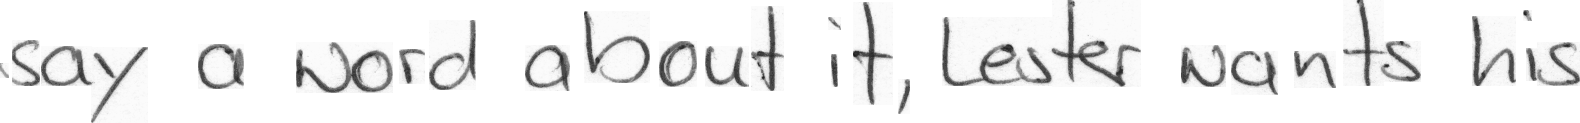

  0%|          | 1/1409 [00:02<49:42,  2.12s/it]

Image:  sentences/m01/m01-022/m01-022-s00-02.png
Label: brought forward .
Prediction:  brought forward .
CER: 0.0; WER: 0.0


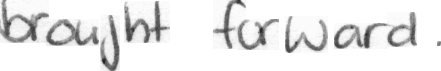

  0%|          | 2/1409 [00:03<46:03,  1.96s/it]

Image:  sentences/n04/n04-068/n04-068-s03-01.png
Label: would have to leave the bar and either sit in
Prediction:  would have to leave the bar and either sit in
CER: 0.0; WER: 0.0


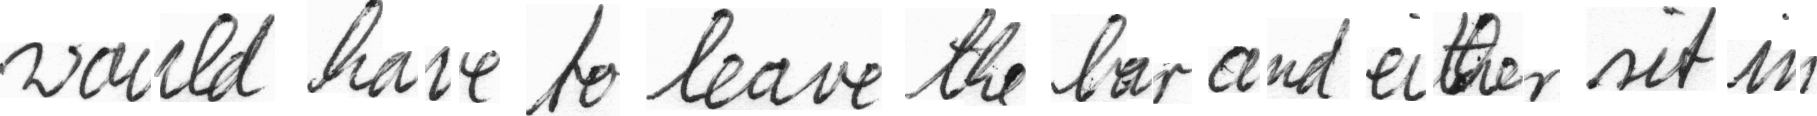

  0%|          | 3/1409 [00:06<47:50,  2.04s/it]

Image:  sentences/h02/h02-028/h02-028-s02-01.png
Label: the heavy and direct responsibility carried by every
Prediction:  the heary and direct responsiblity carried by every
CER: 0.038461538461538464; WER: 0.25


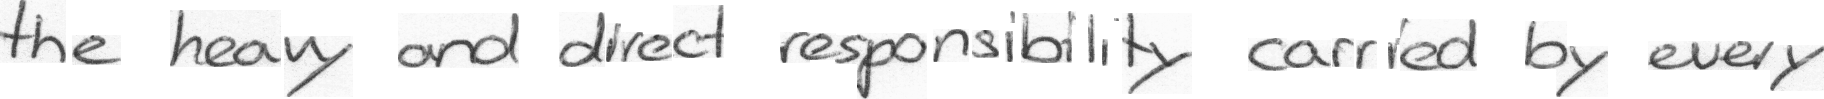

  0%|          | 4/1409 [00:08<47:23,  2.02s/it]

Image:  sentences/m04/m04-038/m04-038-s02-00.png
Label: Somewhere ,
Prediction:  Somerwhere ,
CER: 0.09090909090909091; WER: 0.5


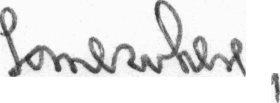

  0%|          | 5/1409 [00:11<55:47,  2.38s/it]


KeyboardInterrupt: ignored

In [13]:
import cv2
import typing
import numpy as np
from google.colab.patches import cv2_imshow

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.transformers import ImageResizer

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = ImageResizer.resize_maintaining_aspect_ratio(image, *self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("/content/drive/MyDrive/English_IAM/Models/04_sentence_recognition/202304240949/configs.yaml")

    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    df = pd.read_csv("/content/drive/MyDrive/English_IAM/Models/04_sentence_recognition/202304240949/val.csv").values.tolist()

    accum_cer, accum_wer = [], []
    for image_path, label in tqdm(df):
        image = cv2.imread(image_path)

        prediction_text = model.predict(image)

        cer = get_cer(prediction_text, label)
        wer = get_wer(prediction_text, label)
        print("Image: ", image_path)
        print("Label:", label)
        print("Prediction: ", prediction_text)
        print(f"CER: {cer}; WER: {wer}")

        accum_cer.append(cer)
        accum_wer.append(wer)

        cv2_imshow(image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    print(f"Average CER: {np.average(accum_cer)}, Average WER: {np.average(accum_wer)}")

Prediction:  first hand writtinn recoquition test .


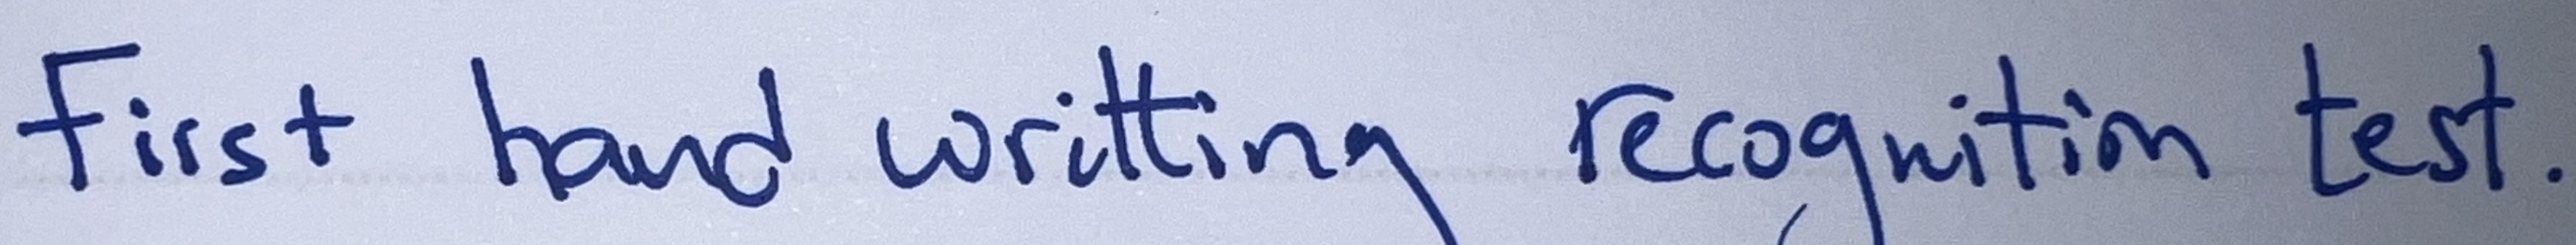

In [20]:
import cv2
import typing
import numpy as np
from google.colab.patches import cv2_imshow

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.transformers import ImageResizer

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = ImageResizer.resize_maintaining_aspect_ratio(image, *self.input_shape[:2][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(None, {self.input_name: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    import pandas as pd
    from tqdm import tqdm
    from mltu.configs import BaseModelConfigs

    configs = BaseModelConfigs.load("/content/drive/MyDrive/English_IAM/Models/04_sentence_recognition/202304240949/configs.yaml")

    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    
    image = cv2.imread('/content/test4.png')

    prediction_text = model.predict(image)

       
    print("Prediction: ", prediction_text)
       
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
